The elastic wave equations are written in terms of stress and velocity. The elastic wave equation is given by:
$$ \dfrac{dv}{dt}=\nabla \tau $$
$$\dfrac{d \tau}{dt} = \lambda \text{diag}(\nabla . v) + \mu (\nabla v + (\nabla v)^T)$$

where v and $\tau$ will be defined as time varying vector and tensor function respectively.



In [1]:
from devito import*
from examples.seismic.source import RickerSource, Receiver, TimeAxis
from examples.seismic import plot_image, ModelElastic
from devito import Grid,TimeFunction, VectorTimeFunction, TensorTimeFunction,div, grad, curl, diag,SubDomain
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Constructing the model for evaluation by seismic model object
# Define a physical size
shape = (101, 101)     # Number of grid point (nx, nz)
spacing = (10., 10.)   # Grid spacing in m. The domain size is now 1km by 1km
origin = (0., 0.)      # What is the location of the top left corner. This is necessary to define
# the absolute location of the source and receivers

# Define a velocity profile. The velocity is in km/s
# As the initial model is taken to be uniform
vp=3*np.ones(shape=shape)
vs=1.5*np.ones(shape=shape)# defining constant velocity for p and s wave in domain at each point in domain
density=2*np.ones(shape=shape)

# With the velocity and model size defined, we can create the seismic model that
# encapsulates these properties. We also define the size of the absorbing layer as 10 grid points and witb the top
#surface free.
model = ModelElastic(vp=vp,vs=vs,origin=origin, b=1/density,shape=shape,fs=True,
                     spacing=spacing,space_order=2,nbl=10, bcs="damp")


Operator `initdamp` run in 0.01 s
Operator `padfunc` run in 0.01 s
Operator `padfunc` run in 0.01 s
Operator `padfunc` run in 0.01 s


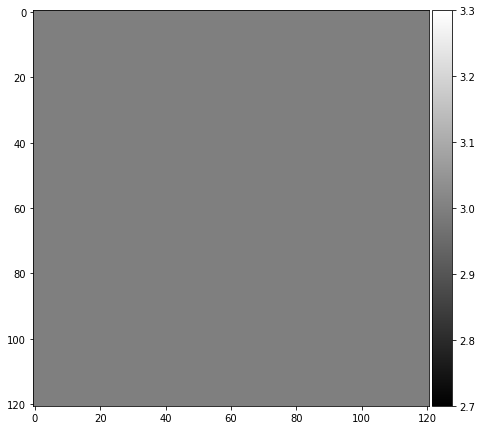

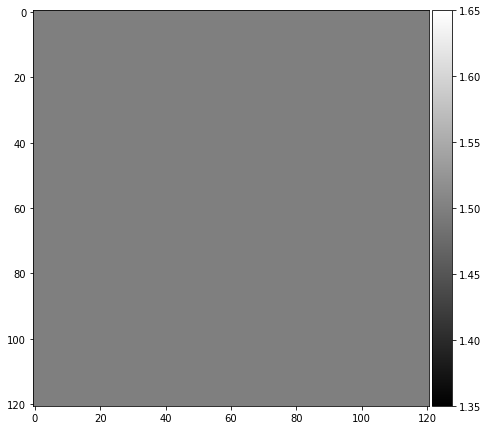

In [3]:
#Now plotting various parameters for the model just for confirmation
model_vp=np.sqrt((model.lam.data[:,:]+2*model.mu.data[:,:])*model.b.data[:,:])
model_vs=np.sqrt(model.mu.data[:,:]*model.b.data[:,:])
plt.figure(figsize=(32,16))

plt.subplot(2,1,1)
plot_image(model_vp[:,:])
plt.figure(figsize=(32,16))
plt.subplot(2,1,2)
plot_image(model_vs[:,:])
plt.show()

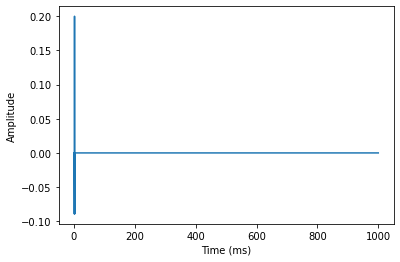

In [4]:
t0, tn = 0., 1000.  #in ms
dt = 0.02            # in ms
time_range = TimeAxis(start=t0, stop=tn, step=dt)

src = RickerSource(name='src', grid=model.grid, f0=0.5, time_range=time_range,a=0.2)
src.coordinates.data[:] = [500., 0.]
src.show()


In [5]:
so = 2         # defining the space order

x, z = model.grid.dimensions    # this assigns the dimensions of the model in symbolic variables x and z
t = model.grid.stepping_dim     # this assigns the stepping variable i.e. t to the given variable
time = model.grid.time_dim      # this assigns time dimension to the given symbolic variable.
s = time.spacing                # this assigns dt -the time spacing to s

v    =  VectorTimeFunction(name='v', grid=model.grid, space_order=so, time_order=1)
tau  =  TensorTimeFunction(name='t', grid=model.grid, space_order=so, time_order=1)

In [6]:
# The source injection term
src_xx = src.inject(field=tau.forward[0, 0], expr=src)
src_zz = src.inject(field=tau.forward[1, 1], expr=src)

# The receiver
nrec = 101
rec1 = Receiver(name="rec", grid=model.grid, npoint=nrec, time_range=time_range)
rec1.coordinates.data[:, 0] = np.linspace(0., model.domain_size[0], num=nrec)
rec1.coordinates.data[:, -1] = 0.0

rec2 = Receiver(name="rec2", grid=model.grid, npoint=nrec, time_range=time_range)
rec2.coordinates.data[:, 0] = np.linspace(0., model.domain_size[0], num=nrec)
rec2.coordinates.data[:, -1] = 20

rec3 = Receiver(name="rec3", grid=model.grid, npoint=nrec, time_range=time_range)
rec3.coordinates.data[:, 0] = np.linspace(0., model.domain_size[0], num=nrec)
rec3.coordinates.data[:, -1] = 20

# initializing the rec_term 
rec_term = rec1.interpolate(expr=tau[0, 0] + tau[1, 1])
rec_term += rec2.interpolate(expr=v[1])
rec_term += rec3.interpolate(expr=v[0])

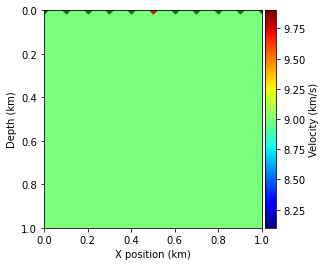

In [7]:
from examples.seismic import plot_velocity
plot_velocity(model, source=src.coordinates.data,
              receiver=rec1.coordinates.data[::10, :])# though it says velcoity it must be clear now that it gives
#lam parameter

In [8]:
# Now let's try and create the staggered updates
# Lame parameters
l, mu, ro = model.lam, model.mu, model.b

# fdelmodc reference implementation
u_v = Eq(v.forward, model.damp * (v + s*ro*div(tau)))
u_t = Eq(tau.forward,  model.damp *  (tau + s * (l * diag(div(v.forward)) +
                                                mu * (grad(v.forward) + grad(v.forward).T))))

op = Operator([u_v] + [u_t] + src_xx + src_zz + rec_term)

In [9]:
u_v

Eq(Vector(v_x(t + dt, x + h_x/2, y), v_y(t + dt, x, y + h_y/2)), Vector((dt*(Derivative(t_xx(t, x, y), x) + Derivative(t_xy(t, x + h_x/2, y + h_y/2), y))*b(x, y) + v_x(t, x + h_x/2, y))*damp(x, y), (dt*(Derivative(t_xy(t, x + h_x/2, y + h_y/2), x) + Derivative(t_yy(t, x, y), y))*b(x, y) + v_y(t, x, y + h_y/2))*damp(x, y)))

In [10]:
u_t

Eq(SymmetricTensor( t_xx(t + dt, x, y), t_xy(t + dt, x + h_x/2, y + h_y/2), t_yy(t + dt, x, y),), Tensor( (dt*((Derivative(v_x(t + dt, x + h_x/2, y), x) + Derivative(v_y(t + dt, x, y + h_y/2), y))*lam(x, y) + 2*mu(x, y)*Derivative(v_x(t + dt, x + h_x/2, y), x)) + t_xx(t, x, y))*damp(x, y), (dt*(Derivative(v_x(t + dt, x + h_x/2, y), y) + Derivative(v_y(t + dt, x, y + h_y/2), x))*mu(x, y) + t_xy(t, x + h_x/2, y + h_y/2))*damp(x, y), (dt*(Derivative(v_x(t + dt, x + h_x/2, y), y) + Derivative(v_y(t + dt, x, y + h_y/2), x))*mu(x, y) + t_xy(t, x + h_x/2, y + h_y/2))*damp(x, y), (dt*((Derivative(v_x(t + dt, x + h_x/2, y), x) + Derivative(v_y(t + dt, x, y + h_y/2), y))*lam(x, y) + 2*mu(x, y)*Derivative(v_y(t + dt, x, y + h_y/2), y)) + t_yy(t, x, y))*damp(x, y),))

In [11]:
op(dt=0.02, time_M=int(1000/0.02))

Operator `Kernel` run in 2.33 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=2.1637680000005415, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=0.003512000000000141, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section2', rank=None),
                     PerfEntry(time=0.054964000000030766, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section3', rank=None),
                     PerfEntry(time=0.046137000000025075, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section4', rank=None),
                     PerfEntry(time=0.04571500000002471, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

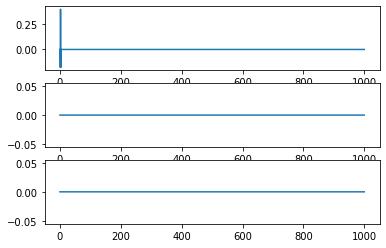

In [12]:
t=np.arange(0,1000.02,0.02)
plt.subplot(3,1,1)
plt.plot(t,rec1.data[:,50])

plt.subplot(3,1,2)
plt.plot(t,rec1.data[:,49])

plt.subplot(3,1,3)
plt.plot(t,rec1.data[:,51])

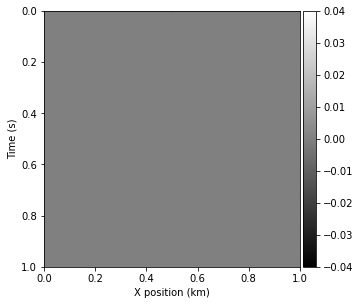

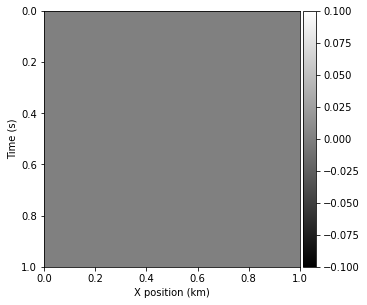

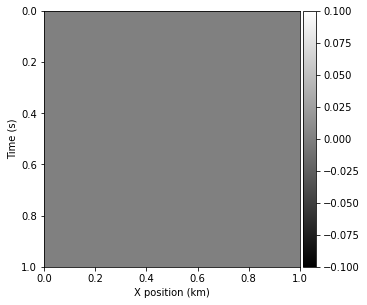

In [13]:
from examples.seismic import plot_shotrecord

plt.figure(figsize=(16,16))
plt.subplot(3,1,1)
plot_shotrecord(rec1.data[:,:400], model, t0, tn)
plt.figure(figsize=(16,16))
plt.subplot(3,1,2)
plot_shotrecord(rec2.data[:,:], model, t0, tn)
plt.figure(figsize=(16,16))
plt.subplot(3,1,3)
plot_shotrecord(rec3.data[:,:], model, t0, tn)

In [14]:
print(np.shape(model.lam.data))

(121, 121)


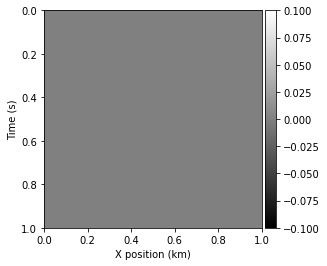

In [15]:
plot_shotrecord(np.zeros_like(rec3.data[:,:]), model, t0, tn)

NameError: name 'p' is not defined